---
## Cell 1: Install PySpark & Mount Google Drive

In this section, we initialize the PySpark environment. Since we are using Google Colab, we first install the `pyspark` library.

**Key Components:**
* `SparkSession`: The entry point for programming Spark with the Dataset and DataFrame API.
* `LinearSVC`: The scalable Support Vector Machine classifier provided by Spark MLlib.
* `RFormula`: A powerful tool that automatically handles one-hot encoding for strings and vector assembly, mimicking R's formula syntax.

In [1]:
# # Install PySpark
# !pip install pyspark -q

# # Mount Drive
# from google.colab import drive
# drive.mount('/content/drive')

# Core Libraries
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, abs as spark_abs, when
from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import RFormula, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics # For confusion matrix

# Initialize Session
spark = SparkSession.builder \
    .appName("CSCI316_Task2_SVM") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark Session Created!")

26/02/21 17:19:43 WARN Utils: Your hostname, ijuwon-ui-MacBookPro.local resolves to a loopback address: 127.0.0.1; using 10.41.87.186 instead (on interface en0)
26/02/21 17:19:43 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/21 17:19:45 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
26/02/21 17:19:51 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Spark Session Created!


---
## Cell 2: Data Loading & Splitting

To ensure a valid comparison with our other models, we implement a consistent data handling strategy:

1.  **Merging Datasets:** We load the original training and testing CSVs and merge them into a single DataFrame. This allows us to perform a global shuffle and split.
2.  **Dropping Leakage:** We remove the `id` and `attack_cat` columns to prevent data leakage.
3.  **Feature Engineering (Manual):**
    * **`pkt_ratio`**: The ratio of source packets to destination packets ($(spkts+1)/(dpkts+1)$).
    * **`ttl_gap`**: The absolute difference between Source TTL and Destination TTL.
    * *Note:* These features mirror the ones created in our Random Forest model for consistency.
4.  **Stratified Split:**
    * We perform a **70% Train / 15% Validation / 15% Test** split.
    * We split the data based on the `label` column to ensure the class distribution (Normal vs. Attack) remains balanced across all three sets.

In [2]:
def load_and_prep_spark_data():
    # Update paths
    train_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_training-set.csv'
    test_path = '/content/drive/MyDrive/University/CSCI316 - Big Data Mining Techniques/Group Assignment/UNSW_NB15_testing-set.csv'

    # Juwon's Local file path
    test_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_testing-set.csv'
    train_path = '/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/Group_Assignment_Database/UNSW_NB15_training-set.csv'
    
    print("Loading data...")
    df_train_orig = spark.read.csv(train_path, header=True, inferSchema=True)
    df_test_orig = spark.read.csv(test_path, header=True, inferSchema=True)

    # 1. Combine Datasets (Fixes Split Mismatch)
    # Drop ID and attack_cat (Fixes Leakage)
    df_full = df_train_orig.unionByName(df_test_orig).drop('id', 'attack_cat')

    # 2. Feature Engineering (Matches RF Features)
    # Add pkt_ratio and ttl_gap so SVM has the same info as RF
    df_full = df_full.withColumn("pkt_ratio", (col("spkts") + 1) / (col("dpkts") + 1))
    df_full = df_full.withColumn("ttl_gap", spark_abs(col("sttl") - col("dttl")))

    print(f"Total Records: {df_full.count()}")

    # 3. Stratified Split (70% Train, 15% Val, 15% Test)
    # We split by label to ensure balance
    zeros = df_full.filter(col("label") == 0)
    ones = df_full.filter(col("label") == 1)

    train_0, val_0, test_0 = zeros.randomSplit([0.7, 0.15, 0.15], seed=42)
    train_1, val_1, test_1 = ones.randomSplit([0.7, 0.15, 0.15], seed=42)

    train_data = train_0.union(train_1)
    val_data = val_0.union(val_1)
    test_data = test_0.union(test_1)

    print(f"Split Sizes -> Train: {train_data.count()}, Val: {val_data.count()}, Test: {test_data.count()}")
    return train_data, val_data, test_data

train_df, val_df, test_df = load_and_prep_spark_data()

Loading data...


Total Records: 257673


26/02/21 17:20:21 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Split Sizes -> Train: 180973, Val: 38573, Test: 38127


---
## Cell 3: Building the SVM Pipeline

We construct a Spark ML `Pipeline` consisting of three stages. This pipeline handles the crucial preprocessing steps required for SVMs.

**Pipeline Stages:**
1.  **`RFormula` (Encoding):**
    * We define the model formula: `label ~ . + dur:sbytes`.
    * This stage automatically converts string columns (`proto`, `service`, `state`) into numerical vectors using **One-Hot Encoding**.
    * It also creates the required interaction term `dur:sbytes`.
2.  **`StandardScaler` (Scaling):**
    * SVM is a distance-based algorithm. If features have vastly different scales (e.g., `sbytes` vs. `sttl`), the model will fail to converge or perform poorly.
    * We scale all features to have unit standard deviation.
3.  **`LinearSVC` (Model):**
    * The linear Support Vector Machine classifier.

In [3]:
def build_svm_pipeline(train_data):
    # 1. Define Features
    # We use the RAW categorical columns (proto, service, state).
    # RFormula will automatically One-Hot Encode them (Correct for SVM).
    categorical_cols = ['proto', 'service', 'state']
    numeric_cols = [f.name for f in train_data.schema.fields
                    if f.dataType.simpleString() != 'string' and f.name != 'label']

    # Construct Formula
    # "label ~ proto + service + ... + dur:sbytes"
    # Note: We include 'dur:sbytes' to satisfy the specific "RFormula new feature" requirement
    all_features = categorical_cols + numeric_cols
    formula_string = "label ~ " + " + ".join(all_features) + " + dur:sbytes"

    print("RFormula String created (includes One-Hot Encoding implicitly).")

    # 2. RFormula (Handles OHE + Interaction)
    rformula = RFormula(
        formula=formula_string,
        featuresCol="raw_features", # Output to raw_features
        labelCol="label_target",
        handleInvalid="keep"
    )

    # 3. StandardScaler (CRITICAL for SVM)
    # SVM converges slowly or fails without scaling
    scaler = StandardScaler(
        inputCol="raw_features",
        outputCol="scaled_features",
        withStd=True,
        withMean=False # LinearSVC supports sparse data if withMean=False
    )

    # 4. LinearSVC
    svm = LinearSVC(
        featuresCol="scaled_features",
        labelCol="label_target",
        maxIter=100
    )

    # Pipeline
    pipeline = Pipeline(stages=[rformula, scaler, svm])
    return pipeline, svm

pipeline, svm_obj = build_svm_pipeline(train_df)

RFormula String created (includes One-Hot Encoding implicitly).


## Cell 4: Training and Hyperparameter Tuning

We use `CrossValidator` to tune the model's hyperparameters on the Training set.

**Grid Search Parameters:**
* **`regParam` (Regularization):** Controls the penalty for complexity. We test values `[0.01, 0.1, 1.0]`.
* **`maxIter`:** The maximum number of iterations for the solver.

**Evaluation Metric:**
* We optimize for **F1 Score** to ensure the model balances False Positives and True Positives effectively.

In [ ]:
rformula_stage = pipeline.getStages()[0]

# 1. Define the Formulas for comparison (Including the toggle)
categorical_cols = ['proto', 'service', 'state']
numeric_cols = [f.name for f in train_df.schema.fields
                if f.dataType.simpleString() != 'string' and f.name != 'label']

all_features = categorical_cols + numeric_cols
formula_with = "label ~ " + " + ".join(all_features) + " + dur:sbytes"
formula_without = "label ~ " + " + ".join(all_features)

# 2. Update ParamGrid: Toggle formula, regParam, and maxIter
paramGrid = ParamGridBuilder() \
    .addGrid(rformula_stage.formula, [formula_with, formula_without]) \
    .addGrid(svm_obj.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(svm_obj.maxIter, [50, 100]) \
    .build()

# 3. Use MulticlassClassificationEvaluator for F1-Score
evaluator = MulticlassClassificationEvaluator(
    labelCol="label_target",
    predictionCol="prediction",
    metricName="f1"
)

# 4. Cross-Validation setup
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3,
    parallelism=2
)

print("Starting SVM Training (Optimizing for F1-Score)...")
start_time = time.time()
cvModel = crossval.fit(train_df)
duration = time.time() - start_time

# 5. Extract and Print Validation Metrics
avg_metrics = cvModel.avgMetrics
params = crossval.getEstimatorParamMaps()
results = sorted(zip(params, avg_metrics), key=lambda x: x[1], reverse=True)

print(f"\nGrid Search Complete in {duration:.2f} seconds.")

print("\n--- All Hyperparameter Combinations (Validation F1) ---")
for i, (p, score) in enumerate(results):
    has_extra = "True" if "dur:sbytes" in p[rformula_stage.formula] else "False"
    reg = p[svm_obj.regParam]
    iters = p[svm_obj.maxIter]
    print(f"Rank {i+1}: F1: {score:.4f} | Extra: {has_extra} | Reg: {reg} | Iter: {iters}")

# Best Model Stats
best_model = cvModel.bestModel
print(f"\nBest Parameters:")
print(f"- Use Extra Feature: {'True' if 'dur:sbytes' in best_model.stages[0].getFormula() else 'False'}")
print(f"- RegParam: {best_model.stages[-1].getRegParam()}")
print(f"- MaxIter: {best_model.stages[-1].getMaxIter()}")
print(f"- Best Validation F1-Score: {max(avg_metrics):.4f}")

Starting SVM Training (Optimizing for F1-Score)...


26/02/21 17:21:47 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


---
## Cell 5: Final Evaluation on Test Set

We evaluate the best model found by Cross-Validation on the unseen **Test Data (15%)**.

**Metrics Calculation:**
* We cast predictions to `FloatType` to utilize Spark's `MulticlassMetrics`.
* We report **Accuracy**, **Weighted Precision**, **Weighted Recall**, and **Weighted F1-Score**.
* A **Confusion Matrix** is plotted to visualize the specific misclassification errors (e.g., how many Attacks were missed).


       FINAL EVALUATION: UNSEEN TEST DATA (SVM)


/Users/jju/Documents/SIM/Semester 1, 2026/CSCI316 Big Data Mining/Assignments/.venv/lib/python3.9/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



--- OVERALL PERFORMANCE (Weighted) ---


Accuracy:           0.897632
Weighted Precision: 0.909090
Weighted Recall:    0.897632
Weighted F1-Score:  0.893407


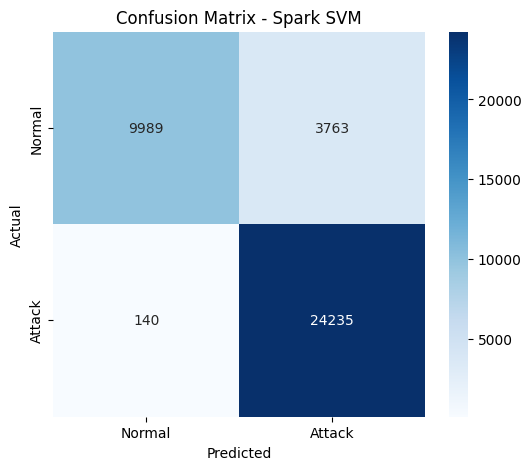

26/02/21 15:51:12 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 759951 ms exceeds timeout 120000 ms
26/02/21 15:51:12 WARN SparkContext: Killing executors is not supported by current scheduler.
26/02/21 15:51:12 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

In [ ]:
from pyspark.sql.types import FloatType

def evaluate_spark_model(model, test_data):
    print("\n" + "="*60)
    print("       FINAL EVALUATION: UNSEEN TEST DATA (SVM)")
    print("="*60)

    # Clean test data (remove potential leftover columns from previous runs)
    cols_to_drop = ["label_target", "raw_features", "scaled_features", "prediction", "rawPrediction"]
    for c in cols_to_drop:
        if c in test_data.columns:
            test_data = test_data.drop(c)

    # Predict
    predictions = model.transform(test_data)

    # Prepare for Metrics (Cast to Float for RDD)
    predictionAndLabels = predictions.select(
        col("prediction").cast(FloatType()),
        col("label_target").cast(FloatType())
    ).rdd

    metrics = MulticlassMetrics(predictionAndLabels)

    # 1. Print Metrics
    print(f"\n--- OVERALL PERFORMANCE (Weighted) ---")
    print(f"Accuracy:           {metrics.accuracy:.6f}")
    print(f"Weighted Precision: {metrics.weightedPrecision:.6f}")
    print(f"Weighted Recall:    {metrics.weightedRecall:.6f}")
    print(f"Weighted F1-Score:  {metrics.weightedFMeasure():.6f}")

    # 3. Confusion Matrix
    cm = metrics.confusionMatrix().toArray()
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues',
                xticklabels=['Normal', 'Attack'],
                yticklabels=['Normal', 'Attack'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Spark SVM')
    plt.show()

evaluate_spark_model(cvModel.bestModel, test_df)